# Contemporary IR methods: retrieval-augmented generation (RAG)

This notebook uses `langchain` with an OpenAI chat model in a simple RAG system. It is based on:

* `langchain` tutorial on RAG: https://python.langchain.com/docs/tutorials/rag/
<!-- * HuggingFace RAG tutorial: https://huggingface.co/learn/cookbook/en/rag_zephyr_langchain. -->

Here's a diagram of RAG from https://huggingface.co/learn/cookbook/en/rag_zephyr_langchain. You will run each of these parts:  
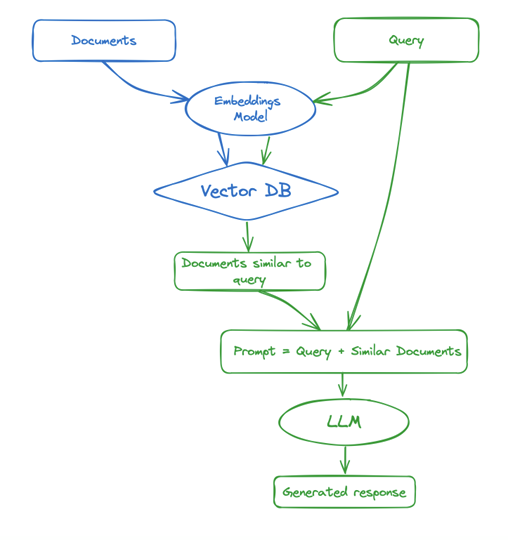

## Setup

Now let's initialize the 2 parts of RAG: an LLM to prompt and an embeddings model to provide embeddings of texts. Here we'll use the open-source decoder LLMs hosted on Pitt SCI's servers for the LLM and the sentence-transformer encoder hosted on Hugging Face as the embedding model.

<span style="color:red">Fill in the Pitt SCI open-source LLMs API key as the `api_key` variable in the next cell.</span> This can be found at the following Canvas announcement (only available to class members): https://canvas.pitt.edu/courses/325983/discussion_topics/1794983

<span style="color:red">Also fill in your choice of open-source model: `llama3.1`, `gemma3`, or `deepseek-r1` as the `model` variable.</span>

In [ ]:
from langchain.chat_models import init_chat_model
from langchain_huggingface import HuggingFaceEmbeddings

# SCI LLM settings
model = '' # llama3.1, gemma3 or deepseek-r1
sci_url = 'https://ol.sci.pitt.edu'
api_key = ''

llm = init_chat_model(
    model=model,
    model_provider="openai",
    base_url=sci_url,
    api_key=api_key
)

embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

# Load and chunk data

Load an example blog post as data to search through for RAG. We'll split the blog post into chunks so we can retrieve only the most relevant parts of the blog post when we need them.

In [ ]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

In [ ]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

# Only keep post title, headers, and content from the full HTML blog post.
bs4_strainer = bs4.SoupStrainer(class_=("post-title", "post-header", "post-content"))
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs={"parse_only": bs4_strainer},
)
docs = loader.load()

assert len(docs) == 1
print(f"Total characters: {len(docs[0].page_content)}")

In [ ]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)

print(f"Split blog post into {len(all_splits)} sub-documents.")

In [ ]:
document_ids = vector_store.add_documents(documents=all_splits)
print(document_ids[:3])

# Define a RAG system
This system includes:

* **Retriever**: Retrieves relevant chunks of the document based on similarity to embeddings of the query. To do this, you first have to get embeddings for the document chunks, which can be provided by a pretrained model (any neural embedding model like BERT or OpenAI's text embeddings would work). This is an alternative to the sparse embeddings you used to do classic IR.
* **Prompt template**: Defines the template text to be filled with a question, the retrieved documents as context, and asking the LLM for its answer.

In [ ]:
from langchain.agents import create_agent
from langchain.agents.middleware import dynamic_prompt, ModelRequest

@dynamic_prompt
def prompt_with_context(request: ModelRequest) -> str:
    """Inject context into state messages."""
    last_query = request.state["messages"][-1].text
    retrieved_docs = vector_store.similarity_search(last_query)

    docs_content = "\n\n".join(doc.page_content for doc in retrieved_docs)

    system_message = (
        "You are a helpful assistant. Use the following context in your response:"
        f"\n\n{docs_content}"
    )

    return system_message


rag_agent = create_agent(llm, tools=[], middleware=[prompt_with_context])

Let's also prepare a system that doesn't use RAG but simply answers the question without documents provided as context.

In [ ]:
llm_agent = create_agent(llm, tools=[], middleware=[])

# Query the RAG and default LLM systems
Test out the RAG system by asking it some questions/prompts. The idea is that by retrieving relevant documents from the example blog post first, the generated responses are more likely to be based on those documents. Are they? Try querying both the rag and default LLM system without RAG.

In [ ]:
def run_query(agent, query):
    """ Prompt an LLM LangChain agent and receive a response. """
    for step in agent.stream(
        {"messages": [{"role": "user", "content": query}]},
        stream_mode="values",
    ):
        step["messages"][-1].pretty_print()

<span style="color:red">Fill in the `query` variable before running the following cell of code.</span> You can uncomment the default question or create your own. Here's the blog post again for reference: https://lilianweng.github.io/posts/2023-06-23-agent/

In [ ]:
# query = ""
# query = "What is the standard method for task decomposition?"
# query = "What is the agent's brain?"
agent = rag_agent
run_query(agent, query)

Try running the same query to an LLM without RAG.

In [ ]:
# query = ""
# query = "What is the standard method for task decomposition?"
# query = "What is the agent's brain?"
agent = llm_agent
run_query(agent, query)

FILL IN your observations of the difference between directly asking the LLM and using RAG here:

# (Optional) Try loading and processing your own corpus

Possibilities:
* [This class's textbook as PDF](https://web.stanford.edu/~jurafsky/slp3/ed3bookaug20_2024.pdf)
* ACL Anthology of NLP papers: [full-text](https://huggingface.co/datasets/WINGNUS/ACL-OCL) or [BibTeX with abstracts](https://aclanthology.org/anthology+abstracts.bib.gz)
* Enron email corpus: [tar.gz](https://www.cs.cmu.edu/~enron/enron_mail_20150507.tar.gz) or [Kaggle download](https://www.kaggle.com/datasets/wcukierski/enron-email-dataset)
* Another website or blog of your choosing!

Note that LangChain has loaders for a huge variety of input text formats. You can see them here: https://python.langchain.com/docs/integrations/document_loaders/